<center>
<h1>Fake news detection using graph neural network</h1>
<h2>SAGE GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk
import torch.nn.functional as F

from torch.nn import Linear, LogSoftmax
from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, train_all_and_optimize
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('../data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class SAGE(torch.nn.Module):
    
    
    def __init__(self, num_n_feature, num_g_feature, emb_size, num_layers=2):
        super(SAGE, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size
        
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            size_in = num_n_feature if i == 0 else emb_size
            self.convs.append(SAGEConv(size_in, emb_size))

        # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)


    
    def forward(self, x, edges_idx, batch_idx, g_features):
        for i, conv in enumerate(self.convs):
            x = conv(x, edges_idx)
            if i != len(self.convs) - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
            else:
                
                flatten = torch.cat([global_mean_pool(x, batch_idx),
                                     global_max_pool(x, batch_idx)], axis=1)

                if g_features.size()[-1] > 1:
                    g_ft = self.lin_g(g_features)
                    flatten = torch.cat([flatten, g_ft], axis=1)

                out = self.act(self.out_layer(flatten))
                
        return out

# Training

In [4]:
models = train_all_and_optimize(SAGE, datasets, epochs = 60)

[I 2022-01-07 11:06:16,895] A new study created in memory with name: no-name-97c3a8de-ea1c-4171-bee4-fd6d936d4f8a


--> Train on: origin


[I 2022-01-07 11:06:38,690] Trial 0 finished with value: 0.9214154411764707 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.9214154411764707.
[I 2022-01-07 11:06:54,783] Trial 1 finished with value: 0.9460477941176471 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.001, 'batch_size': 128, 'embedding_space_dim': 120}. Best is trial 1 with value: 0.9460477941176471.
[I 2022-01-07 11:07:06,446] Trial 2 finished with value: 0.9139859068627452 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 80}. Best is trial 1 with value: 0.9460477941176471.
[I 2022-01-07 11:07:17,880] Trial 3 finished with value: 0.9481847426470589 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.01, 'batch_size': 512, 'embedding_space_dim': 80}. Best is trial 3 with value: 0.9481847426470589.
[I 2022-01-07 11:07:29,818] Trial 4 finished with value: 0.949

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.24449965953826905  loss_val=0.28942204515139264 | acc_train=0.9062959558823529  acc_val=0.9093903186274509
Epochs: 20 | loss_train=0.17334915399551393  loss_val=0.18608022977908453 | acc_train=0.9448988970588236  acc_val=0.9381127450980392
Epochs: 30 | loss_train=0.16343489289283752  loss_val=0.17128188163042068 | acc_train=0.9339154411764706  acc_val=0.9303002450980392
Epochs: 40 | loss_train=0.1453425407409668  loss_val=0.14590094983577728 | acc_train=0.9501838235294118  acc_val=0.953125
Epochs: 50 | loss_train=0.13835604786872863  loss_val=0.14756258577108383 | acc_train=0.9579963235294118  acc_val=0.9439338235294118
Epochs: 60 | loss_train=0.13143707066774368  loss_val=0.1603288079301516 | acc_train=0.9530790441176471  acc_val=0.948529411764706


[I 2022-01-07 11:08:27,176] A new study created in memory with name: no-name-abf5ba87-7e8a-4fc7-93e0-cc91313efe1c


--> Train on: dataset1


[I 2022-01-07 11:08:41,123] Trial 0 finished with value: 0.8923483455882353 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 100}. Best is trial 0 with value: 0.8923483455882353.
[I 2022-01-07 11:08:56,979] Trial 1 finished with value: 0.5973345588235295 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 100}. Best is trial 0 with value: 0.8923483455882353.
[I 2022-01-07 11:09:12,824] Trial 2 finished with value: 0.7693014705882353 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 128, 'embedding_space_dim': 80}. Best is trial 0 with value: 0.8923483455882353.
[I 2022-01-07 11:09:27,778] Trial 3 finished with value: 0.9335171568627452 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.001, 'batch_size': 256, 'embedding_space_dim': 100}. Best is trial 3 with value: 0.9335171568627452.
[I 2022-01-07 11:09:42,169] Trial 4 finished with value: 0.

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.25146372616291046  loss_val=0.35154479146003725 | acc_train=0.9006842320261437  acc_val=0.8651654411764707
Epochs: 20 | loss_train=0.18112460441059536  loss_val=0.1973009377717972 | acc_train=0.9299938725490196  acc_val=0.9182904411764706
Epochs: 30 | loss_train=0.16484050783846113  loss_val=0.18813677430152892 | acc_train=0.9389808006535948  acc_val=0.9296875
Epochs: 40 | loss_train=0.13510245250331032  loss_val=0.17441140115261078 | acc_train=0.9523590686274509  acc_val=0.9319852941176471
Epochs: 50 | loss_train=0.15744443072213066  loss_val=0.13523978739976883 | acc_train=0.9377042483660131  acc_val=0.9534926470588235
Epochs: 60 | loss_train=0.12809587683942583  loss_val=0.1822011426091194 | acc_train=0.9560355392156862  acc_val=0.9401654411764706


[I 2022-01-07 11:11:20,233] A new study created in memory with name: no-name-39b31f76-30d2-4f3f-a830-d378627d10fd


--> Train on: dataset2


[I 2022-01-07 11:11:30,872] Trial 0 finished with value: 0.5555300245098039 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 60}. Best is trial 0 with value: 0.5555300245098039.
[I 2022-01-07 11:11:41,419] Trial 1 finished with value: 0.5637063419117647 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 512, 'embedding_space_dim': 60}. Best is trial 1 with value: 0.5637063419117647.
[I 2022-01-07 11:11:52,455] Trial 2 finished with value: 0.94140625 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 256, 'embedding_space_dim': 60}. Best is trial 2 with value: 0.94140625.
[I 2022-01-07 11:12:07,421] Trial 3 finished with value: 0.8443818933823529 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 120}. Best is trial 2 with value: 0.94140625.
[I 2022-01-07 11:12:24,885] Trial 4 finished with value: 0.8923483455882353 and param

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.35546777248382566  loss_val=0.5795329809188843 | acc_train=0.8606617647058824  acc_val=0.6733302696078431
Epochs: 20 | loss_train=0.2602809309959412  loss_val=0.6399525205294291 | acc_train=0.8926930147058825  acc_val=0.6936274509803922
Epochs: 30 | loss_train=0.23420450687408448  loss_val=0.3977953990300496 | acc_train=0.8999080882352942  acc_val=0.8181678921568628
Epochs: 40 | loss_train=0.20977419018745422  loss_val=0.2707563092311223 | acc_train=0.9304227941176471  acc_val=0.8943780637254902
Epochs: 50 | loss_train=0.20564869046211243  loss_val=0.3814454476038615 | acc_train=0.9137867647058824  acc_val=0.8383118872549019
Epochs: 60 | loss_train=0.16708604991436005  loss_val=0.17730916539827982 | acc_train=0.9321691176470589  acc_val=0.9427083333333334


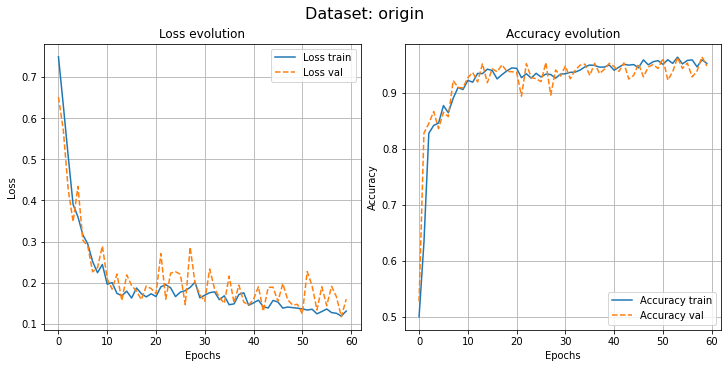

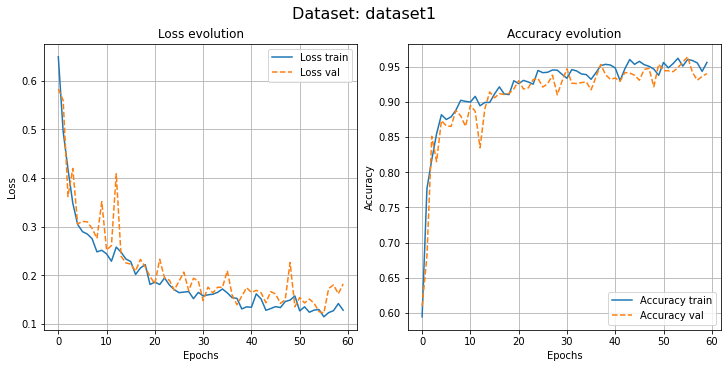

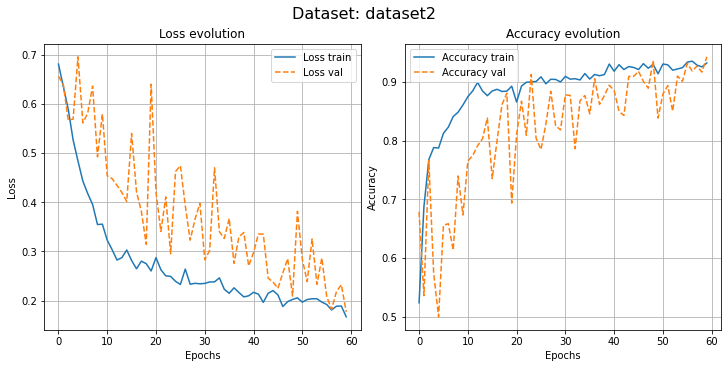

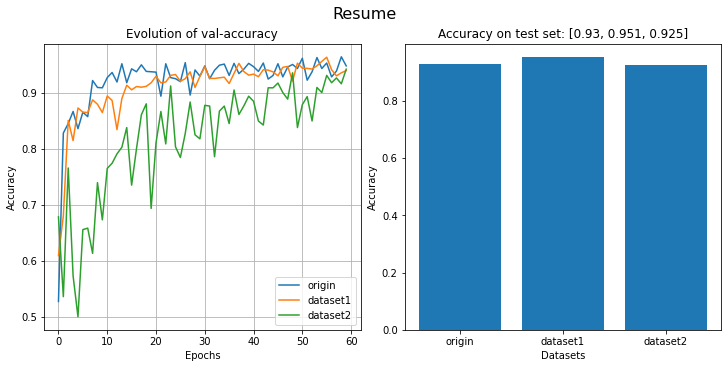

In [5]:
plot_hist(models)

# Save the three models

In [6]:
path = '../models/SAGE/'
for name, model, _, _ in models:
    torch.save(model, f'{path}SAGE_{name}')